In [1]:
import pimdmooc
import numpy as np
import matplotlib.pyplot as plt

# 1. CALCULATING THE FREE ENERGY OF A HAMILTONIAN

### THE MODEL SYSTEM

We will consider the effective Hamiltonian of a hydrogen atom in an effectively 1D double well from Ref.[1]. Its potential energy surface (PES) is described by the function

$V = A x^2 + B x^4 + \frac{1}{2} m \omega^2 y^2 + \frac{1}{2} m \omega^2 z^2$

with 

$m = 1837.107~\text{a.u.}$, 

$\omega = 3800 ~\text{cm}^{-1} = 0.017314074~\text{a.u.}$

$A = -0.00476705894242374~\text{a.u.}$

$B = 0.000598024968321866~\text{a.u.}$

Let's define a function to visualize the PES!

In [2]:
def PES(x, y , z):
    """
    PES from Ref.[1]
    """
    
    A = -0.00476705894242374
    B = 0.000598024968321866 
    k = 1837.107 * 0.017314074**2
    
    return A * x**2 + B * x**4 + k * y**2 / 2 +  k * z**2 / 2

The PES, in three dimensions, can be drawn with xy contours (each contour corresponds to kB T with T = 300 K), for various z values. 

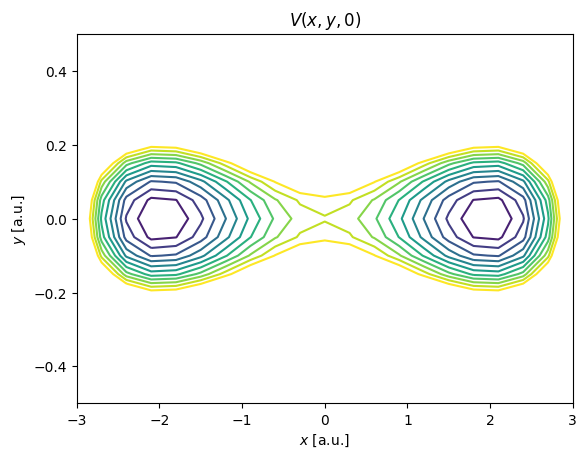

In [3]:
x = np.linspace(-3,3,21)
y = np.linspace(-0.5,0.5,21)

X, Y = np.meshgrid(x, y)
Z = PES(X, Y, 0)


contour_levels = [np.min(Z) + 0.00095004347 * i for i in range(12)]

plt.title(r'$V(x,y,0)$')
plt.xlabel(r'$x$ [a.u.]')
plt.ylabel(r'$y$ [a.u.]')
plt.contour(X, Y, Z, levels=contour_levels)

Q: Looking at the contours can you tell if delocalization of the system to its other minimum is a rare event with respect to the time scale of the system's vibrations?

Q: Feel free to plot it for various z values. Does the plot change? What does it tell you about the coupling between the modes?

### THE HARMONIC APPROXIMATION

The harmonic approximation to the PES is essentially a truncated Taylor series expansion to second order around one of its minima.

$V^{\text{harm}} = V(q_0) + \frac{2}{2} \left.\frac{\partial^2 V}{\partial q^2}\right|_{q_0} (q - q_0)^2$  where  $q = (x,y,z)$ is a position vector and  $q_0 = \text{arg min}_{q} V$ is the position where the PES has a local minimum.

Let's use the i-PI code to optimize the PES with respect to its position to find $q_0$ and $V^{\text{harm}}$.

#### STEP 1: FIXED CELL GEOMETRY OPTIMIZATION

To find $q_0$ we will use the fixed-cell geometry optimization feature of i-PI! Go to the `free_energy` directory

```sh
$ cd free_energy
```

and then into the `geop` directory

```sh
$ cd geop
```

You will find the i-PI input file. Have a look at the `input.xml` file and see if you can understand its various parts. / 

The snippet that implements the geometry optimization feature is 

```xml
    <motion mode='minimize'>
      <optimizer mode='bfgs'>
        <tolerances>
          <energy> 1e-5 </energy>
          <force> 1e-5 </force>
          <position> 1e-5 </position>
        </tolerances>
      </optimizer>
    </motion>
```

In essence, the geometry optimization is implemented as a motion class. At every step instead of performing "dynamics" we will simply move towards a local minimum of the PES. There are many algorithms for locally optimizing high-dimensional functions; here we use the robust [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) method. The tolerances set thershold values for changes in the energy, positions and forces, that are sufficient to deem an optimization converged. 


To perform a fixed-cell geomerty optimization we follow the usual drill 

```sh
$ i-pi input.xml > log.i-pi & 
```

After waiting a moment (few seconds) for i-PI to set itself up, we can run the driver code that implements the effective 1D double well PES


```sh
$ i-pi-driver -u -h geop -m doublewell_1D & 
``

The number of steps taken for an optimization calculation depends on the system (the PES), the optimization method, and the initial configuration. Here, we initialize the system from $q = (2.0, 0.2, -0.5)$ as seen in the `init.xyz` file.

You can analyze your optimization calculation by plotting the potential energy vs steps and confirm if the potential energy has indeed converged to the set threshold!

Text(0.5, 0, '# steps')

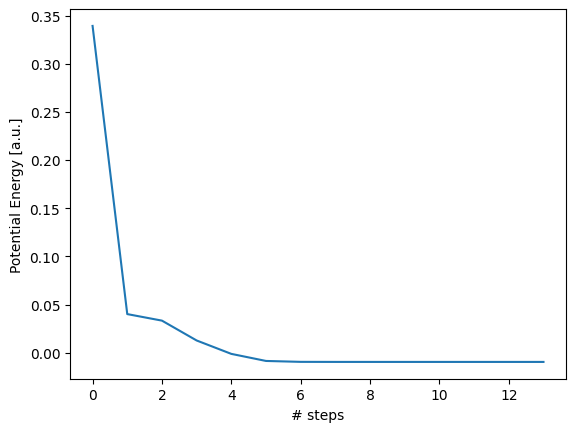

In [4]:
tutorialpath = '/home/vk380/scratch/piqm2023-tutorial/piqm2023-tutorial'
filepath = tutorialpath + '/FREE_ENERGY_METHODS/free_energy/geop/simulation.out'

U = pimdmooc.read_ipi_output(filepath)['potential']
plt.plot(U)
plt.ylabel('Potential Energy [a.u.]')
plt.xlabel('# steps')

The final frame of the `simulation.pos_0.xyz` file gives the optimized position. Can you check, using the `PES` function, if the system is indeed in its local minimum?

#### STEP 2: HARMONIC CALCULATION

To compute the system's Hessian we will use the vibrations feature of i-PI. Go back to the `free_energy` directory and then into the `harm` directory. 

```sh
$ cd harm
```

Go through the `input.xml` file.  

The snippet that implements the vibrations feature is 

```xml
    <motion mode='vibrations'>
      <vibrations mode='fd'>
        <pos_shift> 0.001 </pos_shift>
        <energy_shift> 0.001 </energy_shift>
        <prefix> phonons </prefix>
        <asr> none </asr>
      </vibrations>
    </motion>
```

The system's Hessian is computed using the finite difference method. This approach approximates the ij-th element of the Hessian in terms of the forces acting at infinitisemally displaced positions around the minimum

$\frac{\partial^2 V}{\partial q^2}_{ij} \approx - \frac{1}{2 \epsilon}\left(\left.f_{i}\right|_{q_{j} + \epsilon} - \left.f_{i}\right|_{q_{j} - \epsilon} \right)$

At every step instead of performing "dynamics", we will displace a degree of freedom along $\pm \epsilon$ and estimate one row of the Hessian. `pos_shift` sets the value of $\epsilon$ while `asr`zeros out the blocks of the Hessian due to continuous symmetries (translations or rotations for solids or clusters). In this example, we set this option to `none` as our system doesn't possess any continuous symmetries.

The initial configuration for this calculation should correspond to an opitimized position. You can obtain this from the last frame of the geop trajectory. 

```sh
$ tail -3 ../geop/simulation.pos_0.xyz > init.xyz
```

Run the i-PI phonons calculations as before, i.e.,

```sh
$ i-pi input.xml > log.i-pi & 
```

After waiting a moment (few seconds) run the driver code


```sh
$ i-pi-driver -u -h vib -m doublewell_1D & 
```

The Hessian can be recovered from the `simulation.phonons.hess`file. 
You can use the snippet below to plot the harmonic approximation to the PES

In [5]:
filepath = tutorialpath + '/FREE_ENERGY_METHODS/free_energy/harm/simulation.phonons.hess'
hess = np.loadtxt(filepath, comments='#')

filepath = tutorialpath + '/FREE_ENERGY_METHODS/free_energy/harm/init.xyz'
q0 = pimdmooc.read_ipi_xyz(filepath)[0].positions[0] / 0.529177

filepath = tutorialpath + '/FREE_ENERGY_METHODS/free_energy/harm/simulation.out'
V0 = np.loadtxt(filepath, ndmin=2)[0,1]

# hess = np.loadtxt(filepath)

def PES_harm(x,y,z):
    """
    Harmonic approximation to the PES from Ref.[1] around a local minimum. Note this function is only valid for the example!
    """
    
    return V0 + hess[0,0] * (x - q0[0])**2 / 2 + hess[1,1] * (y - q0[1])**2 / 2 + hess[2,2] * (z - q0[2])**2 / 2


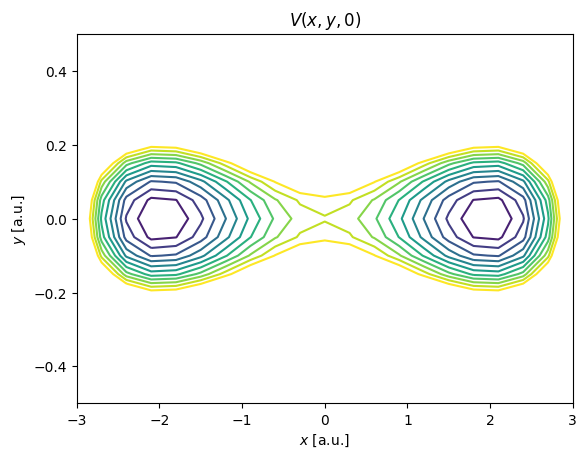

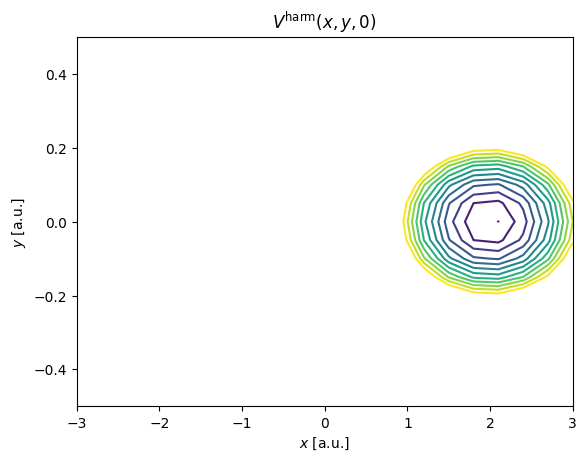

In [6]:
x = np.linspace(-3,3,21)
y = np.linspace(-0.5,0.5,21)

X, Y = np.meshgrid(x, y)

contour_levels = [np.min(Z) + 0.00095004347 * i for i in range(12)]

plt.title(r'$V(x,y,0)$')
plt.xlabel(r'$x$ [a.u.]')
plt.ylabel(r'$y$ [a.u.]')
plt.contour(X, Y, PES(X, Y, 0), levels=contour_levels)
plt.show()

plt.title(r'$V^{\mathrm{harm}}(x,y,0)$')
plt.xlabel(r'$x$ [a.u.]')
plt.ylabel(r'$y$ [a.u.]')
plt.contour(X, Y, PES_harm(X, Y, 0), levels=contour_levels)
plt.show()


The harmonic calculation also  gives us the frequency modes from the dynamical matrix (mass scaled hessian)!

In [7]:
filepath = tutorialpath + '/FREE_ENERGY_METHODS/free_energy/harm/simulation.phonons.eigval'

W2s = np.loadtxt(filepath)
print ('Harmonic Frequencies')
for w2 in W2s:
    print('%10.5f cm^-1'% (w2**0.5 * 219474))

Harmonic Frequencies
 707.03299 cm^-1
3801.20633 cm^-1
3801.20633 cm^-1


In [8]:
def quantum_harmonic_free_energy(Ws, T):
    """
    Receives a list of frequencies in atomic units and the temperature in Kelvin. Returns the system's harmonic free energy.
    """
    
    hbar = 1
    kB = 3.1668116e-06
    
    return V0 + -kB * T * np.log(1 - np.exp(-hbar * Ws / (kB * T))).sum() 

 These frequencies can be used to calculate the quantum harmonic free energy of the system -- an approxiamtion to its true free energy!

In [12]:
print ('Quantum Harmonic free energy: %15.8f [a.u.]'% (quantum_harmonic_free_energy(W2s**0.5, 300)))
print ('Quantum Harmonic free energy: %15.8f [eV]'% (quantum_harmonic_free_energy(W2s**0.5, 300) * 27.211386))
print ('Quantum Harmonic  free energy: %15.8f [kJ/mol]' % (quantum_harmonic_free_energy(W2s**0.5, 300) * 2625.4996))

Quantum Harmonic free energy:     -0.00946741 [a.u.]
Quantum  free energy:     -0.25762138 [eV]
Quantum  free energy:    -24.85668382 [kJ/mol]


The exact free energy for the system when localized in one of the wells is still around 0.65 kJ/mol off w.r.t the harmonic limit. 

In [13]:
F = -7.53132797e-05 + quantum_harmonic_free_energy(W2s**0.5, 300)

print ('Exact Quantum free energy: %15.8f [a.u.]'% (F))
print ('Exact Quantum free energy: %15.8f [eV]'% (F * 27.211386))
print ('Exact Quantum free energy: %15.8f [kJ/mol]' % (F * 2625.4996))

Exact Quantum free energy:     -0.00954272 [a.u.]
Exact Quantum free energy:     -0.25967075 [eV]
Exact Quantum free energy:    -25.05441881 [kJ/mol]


### HARMONIC TO ANHARMONIC

Calculating free energies beyond the harmonic approximation is non-trivial. There exist a familty of methods that can  solve the vibrational Schroedinger Equation by approximating the anharmonic component of the PES, yielding an amharmonic free energy. While highly effective for low-dimensional or mildly anharmonic systems, the method of resort for *numerically-exact amharmonic free energies* of solid and clusters is the thermodynamic integration method combined with the path-integral method (see Refs.[2], [3], [4] for applications ). 

The central idea is to reversibly change the potential from harmonic to anharmonic by defining a $\lambda$-dependent Hamiltonian 

$\hat{H}(\lambda) = \hat{T} + \lambda \hat{V}^{\text{harm}}  + (1 - \lambda) \hat{V}$


The  the anharmonic free energy is calculated as the reversible work done along the fictitious path in $\lambda$-space


$F = F^{\text{harm}} + \left< \hat{V} - \hat{V}^{\text{harm}} \right>_{\lambda}$


where $ \left< \hat{O} \right>_{\lambda}$ is the path-integral estimator for a positon dependent operator for $\hat{H}(\lambda)$.





#### STEP 3: HARMONIC TO ANHARMONIC THERMODYNAMIC INTEGRATION

A full quantum thermodynamic integration calculation requires knowledge of the harmonic reference. Luckily we have just performed these calculations! 

##### CLASSICAL STAT MECH

Let's first compute the anharmonic free energy difference within the classical approximation.


Let's go to the `cti` (classical thermodynamic integration) directory in `free_energies`. 

```sh
$ cd cti
```

The directory contains a sample `input.xml` file that defines a "mixed" $\lambda$-dependent Hamiltonian. Go through it carefully. 

This i-PI calculation includes two "forcefield classes" 

```xml

   <!-->  defines the anharmonic PES <-->
   <ffsocket name='driver' mode='unix' matching='any' pbc='false'>
       <address> f0 </address>
       <latency> 1e-3 </latency>
   </ffsocket>

```

a standard socket 

and 

```xml
   <!-->  defines the harmonic PES <-->
   <ffdebye name='debye'>
           <hessian shape='(3,3)' mode='file'> <!-->  relative path to the system's hessian <--> </hessian>
           <x_reference mode='file'> <!--> relative path to a rile containing the optimized positon vector <-->   </x_reference>
           <v_reference> <!-->  the value of the PES at its local minimum <-->   </v_reference>
   </ffdebye>

```

an intrinsic harmonic forcefield that builds the harmonic potential. This requires $q_0$, $V(q_0)$ and the full Hessian. 

You can create a symlink to the Hessian using

```sh
$ ln -s ../harm/simulation.phonons.hess hessian.data
```

create a ref file containing the positions for the `<x_reference>`  tag using the following

```sh
$ awk '{print $2, $3, $4}' ../harm/init.xyz  | tail -1 | tee ref.data
```

and get `<v_reference>` as 

```sh
$ awk '{print $2}' ../harm/simulation.out  | tail -1 
```


To model a Hamiltonian with a linear combination of the harmonic and the anharmonic potential you can define the weights for the force components as

```xml
      <forces>
         <force forcefield='debye' weight=''> </force>  <!-->  set this to lambda <-->
         <force forcefield='driver' weight=''> </force> <!-->  set this to 1 - lambda <-->
      </forces>
```

You can print out the harmonic and the anharmonic components as a `<property>` in the output class

```xml 
<properties filename='pots' stride='10' flush='10'> [ pot_component_raw(0), pot_component_raw(1) ] </properties>
```


A typical TI calculation requires multiple simulations, one for each lambda and a postprocessing step to integrate the free energy difference. In this example, we use six linearly-spaced points i.e. $ \lambda \in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]$ and create a directory for each calculation. You can checkout the input file in a directory to get see how the calculaion is setup!

You can run i-PI simulataneous in these directories using

```sh
for x in */; do cd ${x}; i-pi input.xml > log.i-pi &  cd ..; done
```

and after waiting for a few seconds run the driver codes with different addresses

```sh
for x in {0..10..2}; do i-pi-driver -u -h f${x} -m doublewell_1D &  done
```

When the calculations have finished, you can use the following snippet to analyze the mean force along the path and estimat its integral!

Text(0, 0.5, '$\\left<U - U^{\\mathrm{harm}}\\right>_{\\lambda}$ [kJ/mol]')

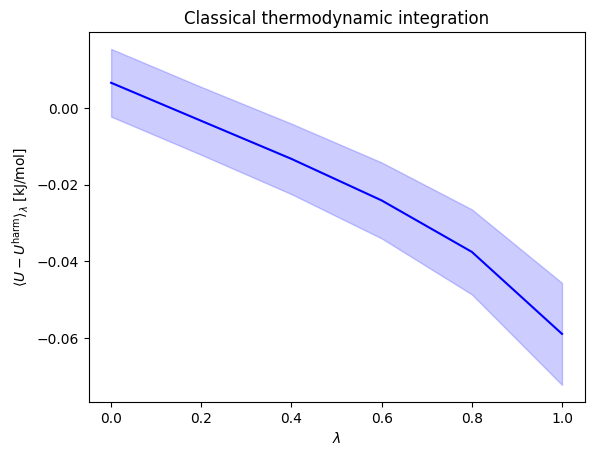

In [31]:
du_list = []
duerr_list = []

dir_list = ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']
l_list = [float(l) for l in dir_list]

for x in ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']:
    
    filename= tutorialpath + '/FREE_ENERGY_METHODS/free_energy/cti'
    filename += '/' + x + '/simulation.pots'
    data = pimdmooc.read_ipi_output(filename)
    
    du = data['pot_component_raw(1)'] - data['pot_component_raw(0)']
    du_list.append(du.mean())
    duerr_list.append(du.std() / len(du)**0.5)
    
    
du_list = np.asarray(du_list)
duerr_list = np.asarray(duerr_list)

plt.plot(l_list, (du_list) * 2625.4996, color='blue')
plt.fill_between(l_list, y1=(du_list - duerr_list)  * 2625.4996, y2=(du_list + duerr_list)  * 2625.4996, color='blue', alpha=0.2)
plt.title('Classical thermodynamic integration')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\left<U - U^{\mathrm{harm}}\right>_{\lambda}$ [kJ/mol]')

Since we are working within classical stat mech, we should use the classical harmonic reference to estimate the classical anharmonic free energy.

In [45]:
def classical_harmonic_free_energy(Ws, T):
    """
    Receives a list of frequencies in atomic units and the temperature in Kelvin. Returns the system's harmonic free energy.
    """
    
    hbar = 1
    kB = 3.1668116e-06
    
    return V0 + kB * T * np.log(hbar * Ws / (kB * T)).sum() 

In [46]:
df, dferr = np.trapz(x=l_list, y=du_list), np.trapz(x=l_list, y=duerr_list**2)**0.5

F = classical_harmonic_free_energy(W2s**0.5, 300)

print ('Classical harmonic free energy: %15.8f [a.u.]'% (F))
print ('Classical harmonic free energy: %15.8f [eV]'% (F * 27.211386))
print ('Classical harmonic free energy: %15.8f [kJ/mol]' % (F * 2625.4996))
print ('')

F = classical_harmonic_free_energy(W2s**0.5, 300) + df
Ferr = dferr


print ('Classical anharmonic free energy: %15.8f +/- %15.8f [a.u.]'% (F, Ferr))
print ('Classical anharmonic free energy: %15.8f +/- %15.8f [eV]'% (F * 27.211386, Ferr * 27.211386))
print ('Classical anharmonic free energy: %15.8f +/- %15.8f [kJ/mol]' % (F * 2625.4996, Ferr * 2625.4996))
print ('')
F = -7.53132797e-05 + quantum_harmonic_free_energy(W2s**0.5, 300)

print ('Exact free energy: %15.8f [a.u.]'% (F))
print ('Exact free energy: %15.8f [eV]'% (F * 27.211386))
print ('Exact free energy: %15.8f [kJ/mol]' % (F * 2625.4996))

Classical harmonic free energy:     -0.00282375 [a.u.]
Classical harmonic free energy:     -0.07683816 [eV]
Classical harmonic free energy:     -7.41375525 [kJ/mol]

Classical anharmonic free energy:     -0.00287980 +/-      0.00001208 [a.u.]
Classical anharmonic free energy:     -0.07836326 +/-      0.00032871 [eV]
Classical anharmonic free energy:     -7.56090536 +/-      0.03171576 [kJ/mol]

Exact free energy:     -0.00954272 [a.u.]
Exact free energy:     -0.25967075 [eV]
Exact free energy:    -25.05441881 [kJ/mol]


###### QUANTUM STAT MECH

You can go to the `qti` directory in `free_energy`. The only difference between a classical and a quantum thermodynamic calculation setup is the number of replicas! Checkout the `input.xml` file. We will need 32 replicas to converge the free energy difference.


```xml
      <initialize nbeads='32'>
         <file mode='xyz'> ../init.xyz </file>
         <velocities mode='thermal' units='kelvin'> 300 </velocities>
      </initialize>
```

You can do the same as in for CTI to setup the hessian, $q_0$, and $V(q_0)$. And run these simulations. The analysis can be done using the snippets below. 


Text(0, 0.5, '$\\left<U - U^{\\mathrm{harm}}\\right>_{\\lambda}$ [kJ/mol]')

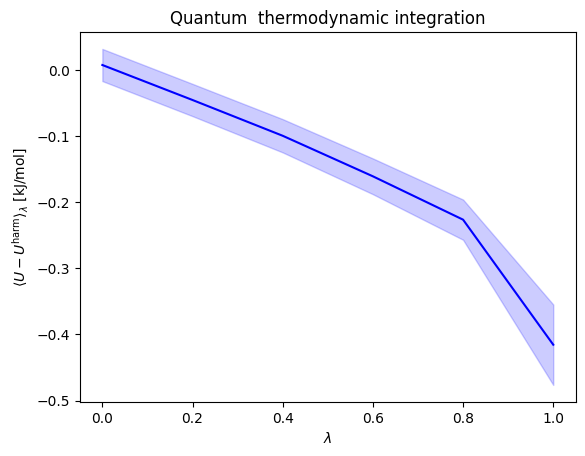

In [47]:
du_list = []
duerr_list = []

dir_list = ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']
l_list = [float(l) for l in dir_list]

for x in ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']:
    
    filename= tutorialpath + '/FREE_ENERGY_METHODS/free_energy/qti'
    filename += '/' + x + '/simulation.pots'
    data = pimdmooc.read_ipi_output(filename)
    
    du = data['pot_component_raw(1)'] - data['pot_component_raw(0)']
    du_list.append(du.mean())
    duerr_list.append(du.std() / len(du)**0.5)
    
    
du_list = np.asarray(du_list)
duerr_list = np.asarray(duerr_list)

plt.plot(l_list, (du_list) * 2625.4996, color='blue')
plt.fill_between(l_list, y1=(du_list - duerr_list)  * 2625.4996, y2=(du_list + duerr_list)  * 2625.4996, color='blue', alpha=0.2)
plt.title('Quantum  thermodynamic integration')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\left<U - U^{\mathrm{harm}}\right>_{\lambda}$ [kJ/mol]')

In [48]:
df, dferr = np.trapz(x=l_list, y=du_list), np.trapz(x=l_list, y=duerr_list**2)**0.5

F = quantum_harmonic_free_energy(W2s**0.5, 300)

print ('Quantum harmonic free energy: %15.8f [a.u.]'% (F))
print ('Quantum harmonic free energy: %15.8f [eV]'% (F * 27.211386))
print ('Quantum harmonic free energy: %15.8f [kJ/mol]' % (F * 2625.4996))
print ('')

F = quantum_harmonic_free_energy(W2s**0.5, 300) + df
Ferr = dferr


print ('Quantum anharmonic free energy: %15.8f +/- %15.8f [a.u.]'% (F, Ferr))
print ('Quantum anharmonic free energy: %15.8f +/- %15.8f [eV]'% (F * 27.211386, Ferr * 27.211386))
print ('Quantum anharmonic free energy: %15.8f +/- %15.8f [kJ/mol]' % (F * 2625.4996, Ferr * 2625.4996))
print ('')
F = -7.53132797e-05 + quantum_harmonic_free_energy(W2s**0.5, 300)

print ('Exact free energy: %15.8f [a.u.]'% (F))
print ('Exact free energy: %15.8f [eV]'% (F * 27.211386))
print ('Exact free energy: %15.8f [kJ/mol]' % (F * 2625.4996))

Quantum harmonic free energy:     -0.00946741 [a.u.]
Quantum harmonic free energy:     -0.25762138 [eV]
Quantum harmonic free energy:    -24.85668382 [kJ/mol]

Quantum anharmonic free energy:     -0.00952346 +/-      0.00001208 [a.u.]
Quantum anharmonic free energy:     -0.25914648 +/-      0.00032871 [eV]
Quantum anharmonic free energy:    -25.00383393 +/-      0.03171576 [kJ/mol]

Exact free energy:     -0.00954272 [a.u.]
Exact free energy:     -0.25967075 [eV]
Exact free energy:    -25.05441881 [kJ/mol]


# 2. [OPTIONAL] CALCULATING FREE ENERGY PROFILES

```$  plumed sum_hills --min -0.30 --max 0.30 --bin 101 --hills plumed/HILLS > fes.dat```

FileNotFoundError: [Errno 2] No such file or directory: '/home/vk380/scratch/piqm2023-tutorial/piqm2023-tutorial/FREE_ENERGY_METHODS/enhanced_sampling/md/simulation.xc.xyz'

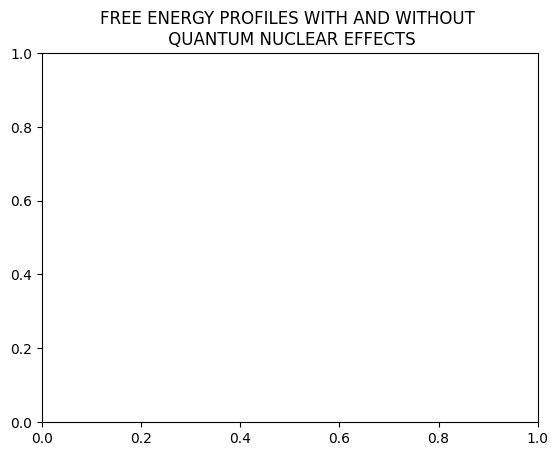

In [49]:
plt.title('FREE ENERGY PROFILES WITH AND WITHOUT \n QUANTUM NUCLEAR EFFECTS')


kBT = 300.0 * 8.314e-3

s = [atoms.positions[0,0] for atoms in pimdmooc.read_ipi_xyz('/home/vk380/scratch/piqm2023-tutorial/piqm2023-tutorial/FREE_ENERGY_METHODS/enhanced_sampling/md/simulation.xc.xyz')]
f, s = np.histogram(s, 51, (0,3), density=True)
f = -kBT * np.log(f)
f = f - np.min(f)

plt.plot(s[1:], f, label='classical')

s, f = np.loadtxt('/home/vk380/scratch/piqm2023-tutorial/piqm2023-tutorial/FREE_ENERGY_METHODS/enhanced_sampling/mtd/fes.dat', usecols=(0,1)).T
s = s * 10.0 
f = (f + f[::-1]) / 2 
f = f - np.min(f)
plt.plot(s, f, label='classical [enhanced]')

kBT = 300.0 * 8.314e-3

s = [atoms.positions[0,0] for atoms in pimdmooc.read_ipi_xyz('/home/vk380/scratch/piqm2023-tutorial/piqm2023-tutorial/FREE_ENERGY_METHODS/enhanced_sampling/pimd/simulation.xc.xyz')]
f, s = np.histogram(s, 51, (0,3), density=True)
f = -kBT * np.log(f)
f = f - np.min(f)

plt.plot(s[1:], f, label='quantum centroid')

s, f = np.loadtxt('/home/vk380/scratch/piqm2023-tutorial/piqm2023-tutorial/FREE_ENERGY_METHODS/enhanced_sampling/pimtd/fes.dat', usecols=(0,1)).T
s = s * 10.0 
f = (f + f[::-1]) / 2 
f = f - np.min(f)
plt.plot(s, f, label='quantum centroid [enhanced]')
plt.legend(frameon=False)

plt.ylabel(r'F(x) [kJ/mol]')
plt.xlabel(r'x [$\AA{}$]')
plt.grid(ls='--')
plt.xlim(-1.48,1.48)

plt.show()

# REFERENCES

[1] 